In [12]:
%load_ext autoreload
%autoreload 2
from pathlib import Path
from hmpai.training import split_participants, split_participants_custom
from hmpai.pytorch.training import train_and_test
from hmpai.pytorch.utilities import set_global_seed, load_model, DEVICE
from hmpai.pytorch.generators import MultiXArrayProbaDataset
from hmpai.pytorch.normalization import *
from torchvision.transforms import Compose
from hmpai.pytorch.transforms import *
from hmpai.pytorch.mamba import *
from hmpai.visualization import plot_single_epoch
import os
from torch.utils.data import DataLoader

DATA_PATH = Path(os.getenv("DATA_PATH"))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
set_global_seed(42)

data_paths = [DATA_PATH / "prp/stage_data_250hz_t1.nc", DATA_PATH / "prp/stage_data_250hz_t2.nc"]
# 80/20 train/val (no test)
splits = split_participants_custom(data_paths, 0.15)
# # Labels per dataset (same order as data_paths)
# data_labels = [["negative", "t1_1", "t1_2", "t1_3"], ["negative", "t2_1", "t2_2", "t2_3"]]
# # Labels combined
# labels = ["negative", "t1_1", "t1_2", "t1_3", "t2_1", "t2_2", "t2_3"]
# Labels per dataset (same order as data_paths)
data_labels = [["negative", "encoding", "t1_2", "response"], ["negative", "encoding", "t2_2", "response"]]
# Labels combined
labels = ["negative", "t1_1", "t1_2", "t2_1", "t2_2", "response"]
info_to_keep = []
subset_cond = ('condition', 'equal', 'long')
add_negative = True
skip_samples = 0 # 62
cut_samples = 0 # 63
add_pe = True

In [14]:
norm_fn = norm_mad_zscore
# train_data = MultiXArrayProbaDataset(
#     data_paths,
#     participants_to_keep=splits[0],
#     normalization_fn=norm_fn,
#     labels=labels,
#     data_labels=data_labels,
#     info_to_keep=info_to_keep,
#     subset_cond=subset_cond,
#     add_negative=add_negative,
#     transform=Compose([StartJitterTransform(62, 1.0), EndJitterTransform(63, 1.0)]),
#     skip_samples=skip_samples,
#     cut_samples=cut_samples,
#     add_pe=add_pe,
# )
# norm_vars = get_norm_vars_from_global_statistics(train_data.statistics, norm_fn)
# class_weights = train_data.statistics["class_weights"]
val_data = MultiXArrayProbaDataset(
    data_paths,
    participants_to_keep=splits[1],
    normalization_fn=norm_fn,
    # norm_vars=norm_vars,
    labels=labels,
    data_labels=data_labels,
    info_to_keep=info_to_keep,
    subset_cond=subset_cond,
    add_negative=add_negative,
    skip_samples=skip_samples,
    cut_samples=cut_samples,
    add_pe=add_pe,
)

In [15]:
val_loader = DataLoader(
    val_data, batch_size=128, shuffle=True, num_workers=0, pin_memory=True
)

In [16]:
chk_path = Path("../models/cmb_pe_new.pt")
checkpoint = load_model(chk_path)
config = {
    "n_channels": 64,
    "n_classes": len(labels),
    "n_mamba_layers": 5,
    "use_pointconv_fe": True,
    "spatial_feature_dim": 128,
    "use_conv": True,
    "conv_kernel_sizes": [3, 9],
    "conv_in_channels": [128, 128],
    "conv_out_channels": [256, 256],
    "conv_concat": True,
    "use_pos_enc": add_pe,
}

model = build_mamba(config)
model.load_state_dict(checkpoint["model_state_dict"])
model = model.to(DEVICE)
model.eval();

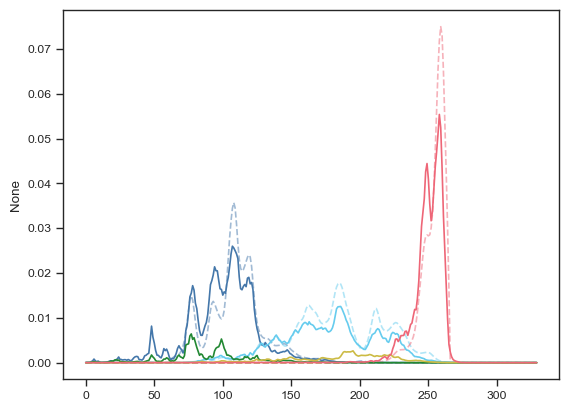

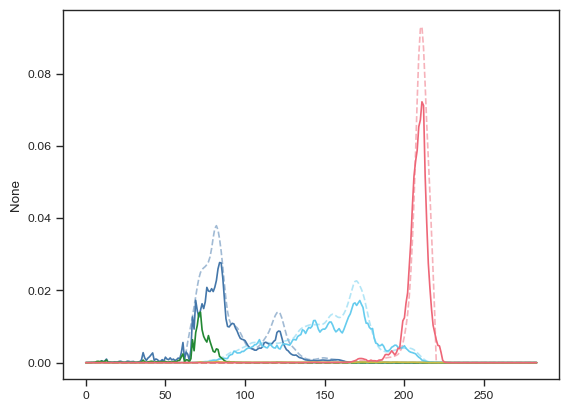

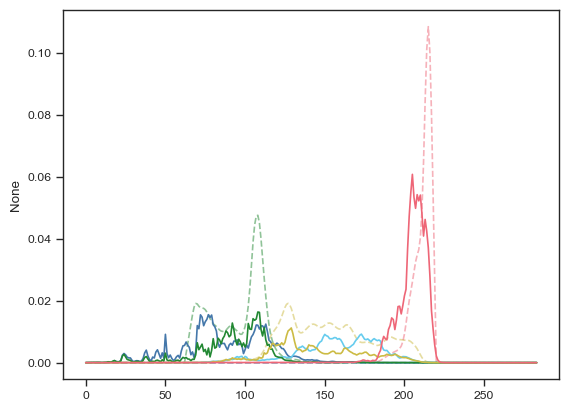

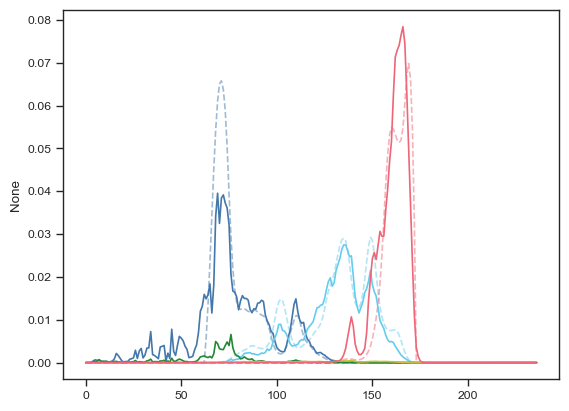

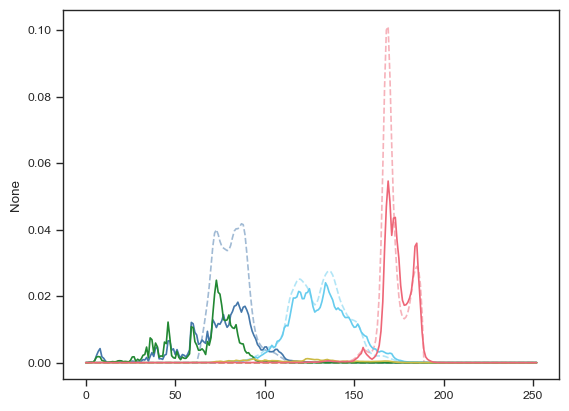

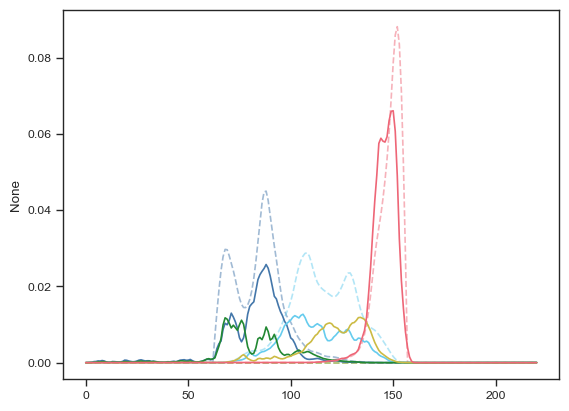

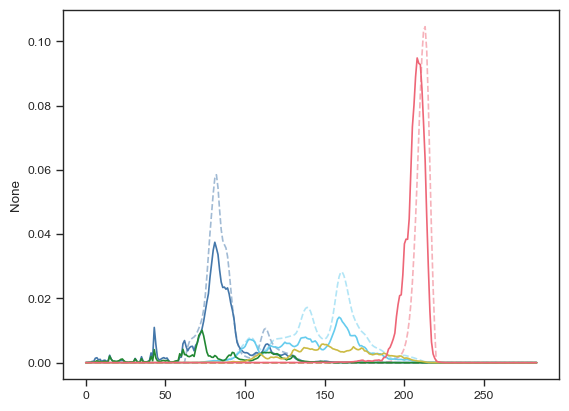

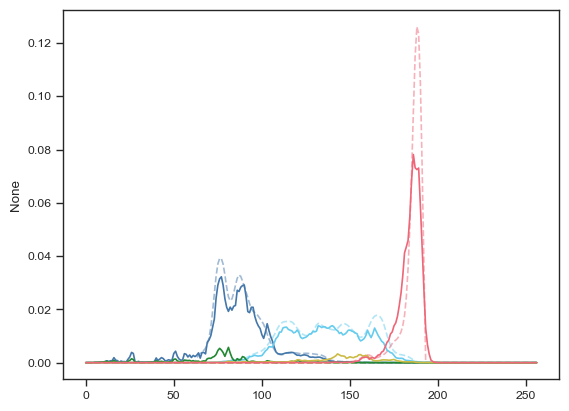

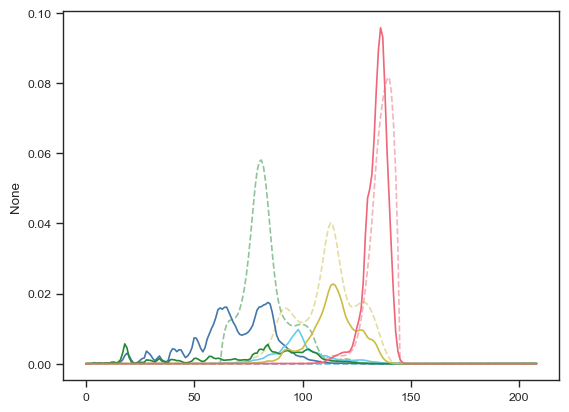

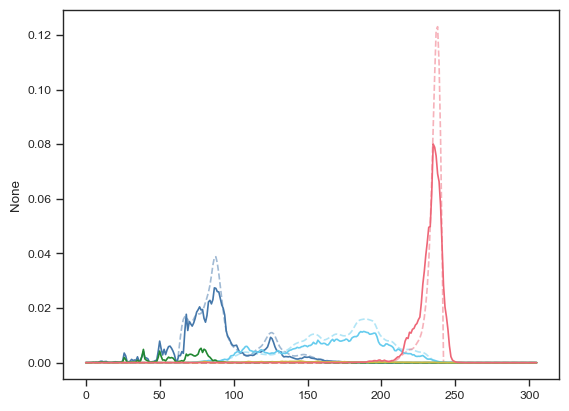

In [30]:
import matplotlib.pyplot as plt
import random
for i in list(random.sample(range(0, len(val_data)), 10)):
    fig, ax = plt.subplots(1, 1)

    plot_single_epoch(val_data.__getitem__(i), labels, model, ax)
    plt.show()